## Notice FADC400 확인하기
이 예제에서는 python을 이용해 Notice의 FADC400 데이터를 읽는 방법을 보여드립니다.

### 필요한 패키지
pyROOT 가 설치되어 있어야 하고, numpy, matplotlib이 설치되어 있어야 합니다. \
tqdm 패키지는 단순히 진행 과정을 보여주기 위한 용도인데, anaconda에서 ROOT를 설치하면 자동으로 함께 설치 되는 것 같습니다.

```
conda install -c conda-forge matplotlib numpy numba tqdm
conda install -c conda-forge root
```

In [25]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm

### FADC 설정값 지정하기
전남대학교에서 보유한 FADC400 장비에서는 time window는 4096개 bin, channel의 갯수는 4개로 되어 있습니다. \
400MHz x 4096개 bin이므로 전체 시간은 10.24 micro-sec 인 듯 합니다. \

In [34]:
timeWindow = 4096
nChannels = 4
fileName = "Cs137_CsI_1500V_Evt1000.root"

In [35]:
f = ROOT.TFile(fileName)

### 데이터 파일 안에 저정된 정보 읽기
root file을 열면 몇 개의 tree들을 볼 수 있습니다. head, nfadc를 확인할 수 있는데, \
head에는 데이터 수집시 하드웨어 설정 관련 정보를 읽을 수 있습니다. 이 예제에서는 Print()와 Show()함수로
저장된 정보를 화면에 단순 출력만 해 보았습니다. 

만약 값을 읽어서 활용해야 한다면 struct를 만든 뒤 SetBranchAddress등을 실행해 내용을 읽어야 합니다.

In [28]:
## Print out the header tree
## The header tree contains information about the FADC configuration
## such as gain, delay etc, etc.
## There are 4 input channels in this FADC400 hardware, by the Notice Korea inc.

tree_head = f.Get("head")
tree_head.Print()
tree_head.Show()

******************************************************************************
*Tree    :head      : Head of Run                                            *
*Entries :        1 : Total =            2395 bytes  File  Size =        926 *
*        :          : Tree compression factor =   1.79                       *
******************************************************************************
*Br    0 :head1     : rl/I:offset[4]/I:gain[4]/I:ped[4]/I:delay[4]/I:tlt/I:  *
*         | tow/I:dce/I:pol[4]/I:thr[4]/I:dt[4]/I:cw[4]/I:tm[4]/I:pct[4]/I:  *
*         | pci[4]/I:pwt[4]/F                                                *
*Entries :        1 : Total  Size=       1984 bytes  File Size  =        156 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.79     *
*............................................................................*
======> EVENT:-1
 rl              = 0
 offset          = 0, 
                  0, 0, 0
 gain            = 0, 
                  0, 

### FADC에 기록된 내용 읽기
FADC 트리 안의 내용을 확인합니다. \
아래에서 보이는 것처럼 trigger[2], tag[6], FADC[16384]/F 로 내용이 들어 있습니다. \
MakeClass등으로 확인 한 결과에서는 trigger, tag는 unsigned char로, FADC는 float 타입인 것으로 보이는데,
SetBranchAddress등으로 읽기 위해서는 struct 형태로 묶어서 읽어주어야 합니다.

In [36]:
tree_fadc = f.Get("nfadc400")
tree_fadc.Print()

******************************************************************************
*Tree    :nfadc400  : nfadc400 file                                          *
*Entries :     1000 : Total =        65639857 bytes  File  Size =    9894684 *
*        :          : Tree compression factor =   6.64                       *
******************************************************************************
*Br    0 :fadc      : trigger[2]/b:tag[6]/b:FADC[16384]/F                    *
*Entries :     1000 : Total  Size=   65639486 bytes  File Size  =    9886224 *
*Baskets :     1000 : Basket Size=      32000 bytes  Compression=   6.64     *
*............................................................................*


아래에서 보는 것처럼 struct로 만든 다음, SetBranchAddress로 읽을 수 있도록 해 주어야 합니다.

In [37]:
ROOT.gROOT.ProcessLine("""
struct TFADC {
    unsigned char trigger[2];
    unsigned char tag[6];
    float FADC[16384];
};
""")

bFADC = ROOT.TFADC()
tree_fadc.SetBranchAddress("fadc", bFADC);

### Tree에서 내용 읽기
여기에서는 Tree에서 내용을 읽어 numpy array에 저장합니다. \
numpy array를 쓰지 않고 매 event loop마다 데이터 분석을 해도 되지만, 이 예제에서는 array에 담도록 했습니다. numpy의 ndarray를 이용하면 데이터 선별이나 각종 수치 계산을 매우 빠르게 할 수 있습니다. 

FADC 엔트리의 내용은 바로 위의 예시에서 보이는 것처럼 16384개의 float number로 되어 있는데, 각 이벤트별로 4개 채널의 FADC 데이터를 일렬로 길게 늘여 붙인 형태로, 한 채널당 4096개 데이터가 들어 있습니다. \
numpy array로 읽은 다음, 4x4096의 2차원 배열로 형태를 바꾼 다음 각 채널별로 처리하면 됩니다.

여기에서는 0번 채널로만 데이터를 받았기 때문에 0번 채널 값만 따서 fadc0에 이벤트별로 복사해 넣습니다.

In [31]:
nEntries = tree_fadc.GetEntries()
fadc0 = np.zeros( (nEntries, timeWindow) )

for iEntry in tqdm(range(nEntries)):
    tree_fadc.GetEntry(iEntry)
    a = np.array(bFADC.FADC).reshape(nChannels,timeWindow) ## split 4 FADC channels
    
    fadc0[iEntry] = a[0]

100%|██████████| 1000/1000 [00:00<00:00, 3568.00it/s]


### FADC channel0번 내용 확인하기
FADC에 받아진 펄스 형태를 확인합니다. 모든 데이터를 다 그리지는 않고, 10개만 뽑아 펄스 형태를 그려보면 아래와 같습니다.

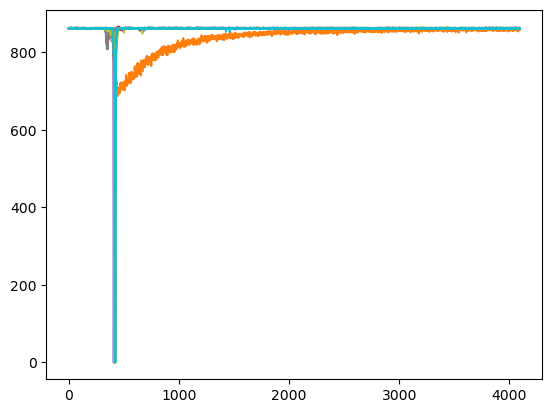

In [38]:
## Draw 10 example pulses
for i in range(10):
    plt.plot(fadc0[i])